In [1]:
# RNN on sine wave, using bp on weight matrix, enforce Dale's law (exponential)
import numpy as np
import sys
sys.path.append("../../model")
from rnn_sin2_exp import RNN
import matplotlib.pyplot as plt
import json
import torch
import torch.nn as nn
import seaborn as sns
from tqdm.notebook import tqdm

## Loading Trained Weights

In [2]:
num_nodes = 16
filedir = "../weights/"
filename = "SIN2_wtexppt_" + str(num_nodes) + "_nodes.json"
filepath = filedir + filename
with open(filepath) as f:
    weight_history = json.load(f)

In [3]:
weight_history.keys()

dict_keys(['trained gain', 'trained shift', 'trained weights', 'connectivity matrix', 'input weights', 'output weights', 'losses', 'init_weight', 'init_activations'])

In [4]:
gains = np.array(weight_history['trained gain'])
shifts = np.array(weight_history['trained shift'])
log_weight_matrix = np.array(weight_history['trained weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
input_weight_matrix = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
init_activations = np.array(weight_history['init_activations'])
losses = np.array(weight_history['losses'])

# Dale's Law
num_nodes = 16
excite_perc = 0.5
excite_num = int(excite_perc*num_nodes)
node_type = [1]*excite_num + [-1]*(num_nodes-excite_num)
weight_type = np.tile(node_type, num_nodes).reshape(num_nodes, -1)

In [5]:
np.max(np.exp(log_weight_matrix))

22.05521874256357

Text(0.5, 1.0, 'Weight matrix')

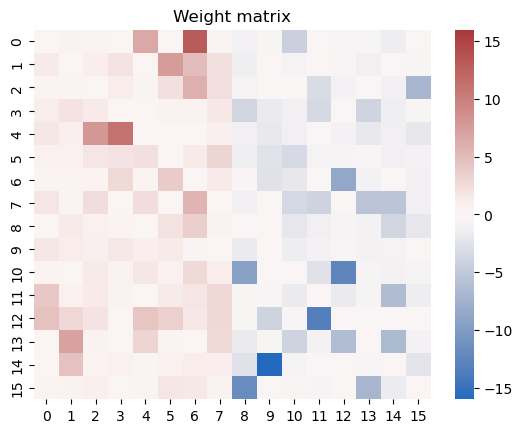

In [6]:
sns.heatmap(np.exp(log_weight_matrix) * connectivity_matrix * weight_type, vmax=16, vmin=-16, cmap='vlag')
plt.title('Weight matrix')

In [7]:
excite_weights = np.exp(log_weight_matrix) * connectivity_matrix * (weight_type > 0)
np.sum(excite_weights)

215.0361182783043

In [8]:
inhibit_weights = np.exp(log_weight_matrix) * connectivity_matrix * (weight_type < 0)
np.sum(inhibit_weights)

261.5793331399909

In [9]:
np.exp(log_weight_matrix)

array([[ 5.0750959 ,  0.65673242,  0.61748744,  0.34873267,  6.58336205,
         0.10154344, 13.04135843,  0.47108371,  1.08192143,  0.65031638,
         4.31503636,  0.12468622,  0.58484197,  0.66666173,  1.55420417,
         0.33223068],
       [ 1.2846626 ,  0.41567216,  1.10494362,  1.95872763,  0.3637077 ,
         7.65797271,  4.97901935,  2.13929465,  1.40134114,  0.45015069,
         0.88435842,  0.34827904,  0.63146825,  1.28332016,  0.44829072,
         0.66715595],
       [ 0.5242282 ,  0.44256902,  0.51107133,  1.15998635,  0.39354038,
         2.20338111,  6.03285922,  2.34399633,  0.9504204 ,  0.36782949,
         0.47371791,  3.24388485,  1.04276929,  0.49164283,  1.23151138,
         6.95834407],
       [ 1.14162944,  1.95900131,  1.44432731,  0.70310442,  0.33115999,
         0.69587922,  0.73800886,  1.56059632,  3.84222022,  1.83945   ,
         1.33054324,  3.4128054 ,  0.45076428,  3.9316557 ,  1.42931365,
         0.73723036],
       [ 1.67352017,  0.91487072,  8

## Defining Network

In [10]:
time_constant = 100 #ms
timestep = 10 #ms
ndata = 800
time = ndata * timestep #ms
num_inputs = 1

  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [00:00<00:00, 13213.06it/s]


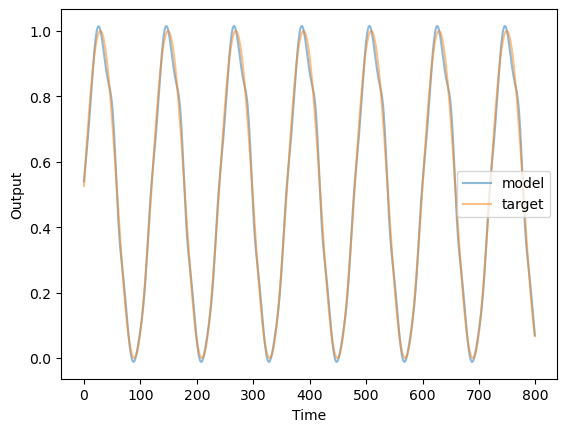

In [11]:
time_points = np.arange(ndata).reshape(-1, 1)
inputs = (1 + np.sin(time_points/60*np.pi))/2
targets = (1 + np.sin((time_points+1)/60*np.pi))/2
inputs = inputs.reshape(-1, 1)
targets = targets.reshape(-1, 1)

network = RNN(log_weight_matrix, weight_type, connectivity_matrix, init_activations, gains, shifts, input_weight_matrix, output_weight_matrix, 
                time_constant = time_constant, timestep = timestep)
outputs, activations = network.simulate(time, torch.tensor(inputs).float())

fig, ax = plt.subplots()
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
plt.plot(time_points, targets.squeeze(), alpha=0.5, label='target')
# plt.ylim([0,1])
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
# plt.savefig("fig/0122_SIN2_bphebbpt_output.png")

Text(50.722222222222214, 0.5, 'Node')

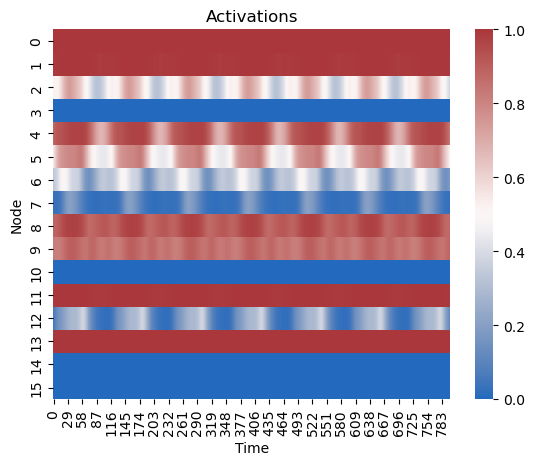

In [12]:
activations_t = activations.detach().numpy().T
sns.heatmap(activations_t, cmap='vlag', vmax=1, vmin=0)
plt.title('Activations')
plt.xlabel('Time')
plt.ylabel('Node')
# plt.savefig('fig/0221_SIN2_bphcppt_activations.png')

(0.0, 0.1)

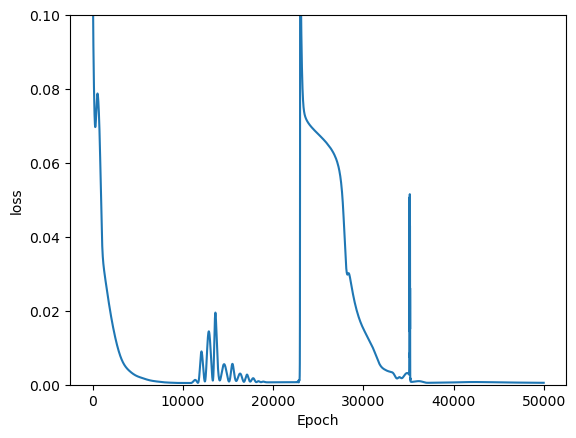

In [13]:
plt.plot(np.arange(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.ylim([0,0.1])
# plt.savefig("fig/sin_oja_loss.png")